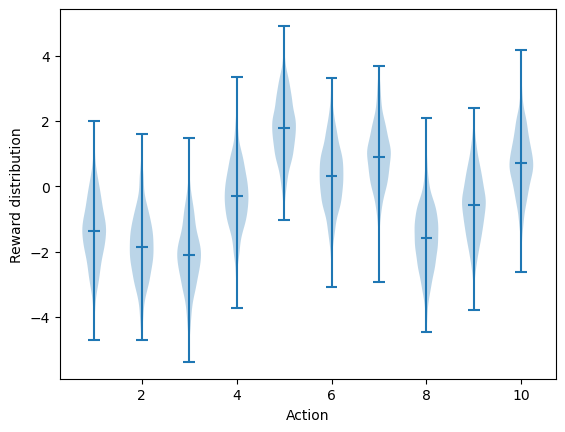

In [5]:
import matplotlib.pyplot as plt
from bandit import MultiArmedBanditEnv
from gambler import Gambler, AveragingGambler, FixedLearningStepGambler

bandit_env = MultiArmedBanditEnv()
bandit_env.render()

In [6]:
import ray
import numpy as np

ray.shutdown()
ray.init()


@ray.remote
def run_episode(
    bandit: MultiArmedBanditEnv, gambler: Gambler, max_time_steps: int = 1e3
):
    rewards = []
    best_action_counts = []
    bandit.reset()
    gambler.reset()
    for _ in range(max_time_steps):
        action = gambler.act()
        reward = bandit.step(action)
        gambler.update(action, reward)
        rewards.append(reward)
        best_action_counts.append(1 if action == bandit.best_action else 0)
    return rewards, best_action_counts


def simulate(
    bandit: MultiArmedBanditEnv,
    gambler: Gambler,
    num_of_episodes: int = 2e3,
    max_time_steps: int = 1e3,
):
    bandit_id = ray.put(bandit)
    gambler_id = ray.put(gambler)
    rewards = np.zeros((num_of_episodes, max_time_steps))
    best_action_counts = np.zeros(rewards.shape)
    episodes = ray.get(
        [
            run_episode.remote(bandit_id, gambler_id, max_time_steps)
            for _ in range(num_of_episodes)
        ]
    )
    for i, (episode_rewards, episode_best_action_counts) in enumerate(episodes):
        rewards[i, :] = episode_rewards
        best_action_counts[i, :] = episode_best_action_counts
    mean_rewards = rewards.mean(axis=0)
    mean_best_action_counts = best_action_counts.mean(axis=0)
    return mean_rewards, mean_best_action_counts


2022-12-04 23:48:52,900	INFO worker.py:1528 -- Started a local Ray instance.


In [7]:
from typing import Type, Optional

def exercise_2_5(bandit: MultiArmedBanditEnv, gambler_cls: Type[Gambler], gambler_args: Optional[dict] = None):
    fig, (mean_reward_plot, mean_best_action_plot) = plt.subplots(1, 2, figsize=(12, 4))
    plot_title = f"{gambler_cls.__name__} - {'Stationary' if bandit.stationary else 'Non-stationary'}" 
    mean_reward_plot.set_title(plot_title)
    mean_reward_plot.set_xlabel("Steps")
    mean_reward_plot.set_ylabel("Avg reward")
    mean_best_action_plot.set_title(plot_title)
    mean_best_action_plot.set_xlabel("Steps")
    mean_best_action_plot.set_ylabel("% Optimal action")
    for epsilon in [0, 0.01, 0.1]:
        mean_rewards, mean_best_action_counts = simulate(
            bandit,
            gambler_cls(epsilon=epsilon, **(gambler_args or {})),
            num_of_episodes=int(2e3),
            max_time_steps=int(5e2),
        )
        mean_reward_plot.plot(mean_rewards, label="$\epsilon = %.02f$" % (epsilon))
        mean_best_action_plot.plot(
            mean_best_action_counts * 100, label="$\epsilon = %.02f$" % (epsilon)
        )
    mean_reward_plot.legend()
    mean_best_action_plot.legend()
    plt.show()

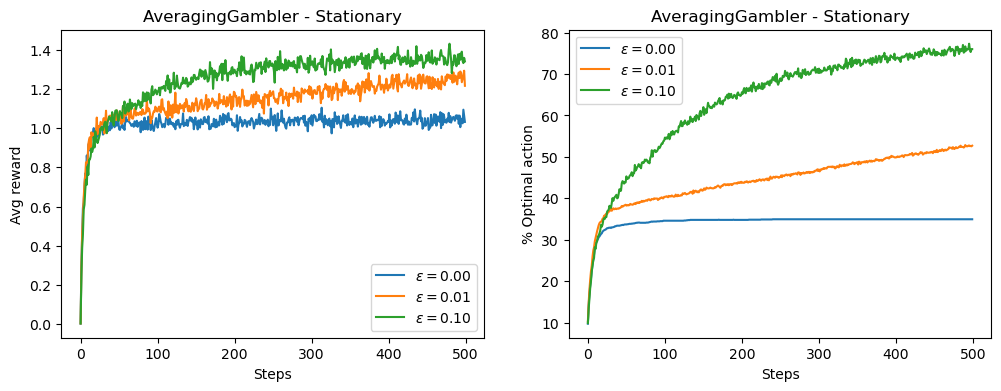

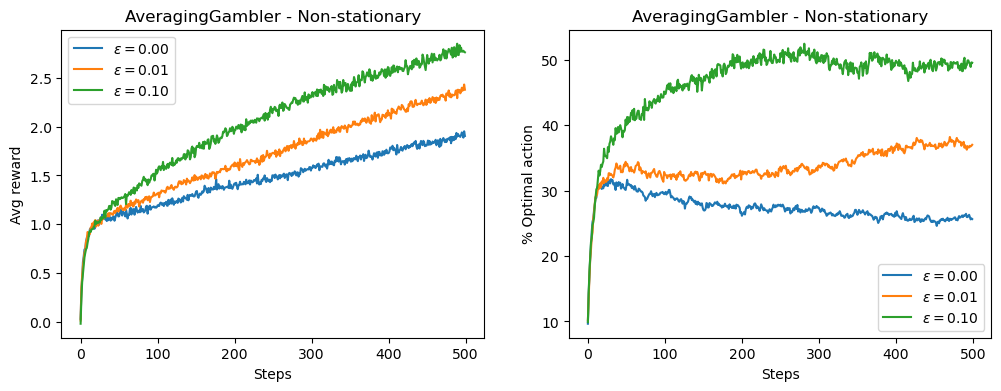

In [8]:
exercise_2_5(MultiArmedBanditEnv(stationary=True), AveragingGambler)
exercise_2_5(MultiArmedBanditEnv(stationary=False), AveragingGambler)

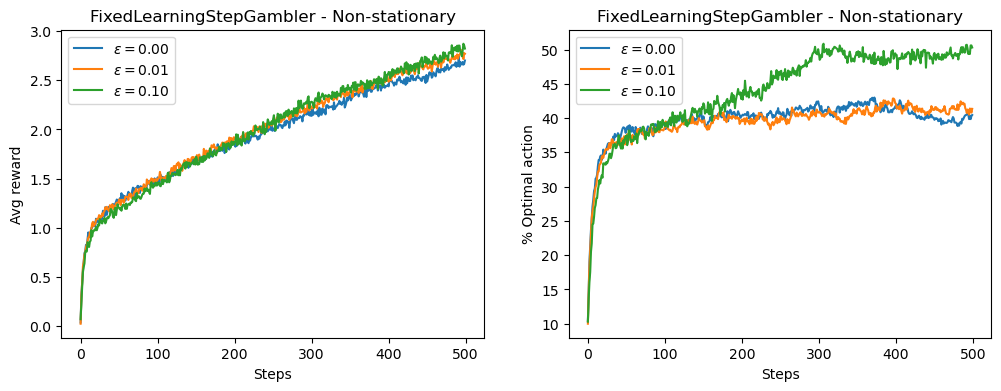

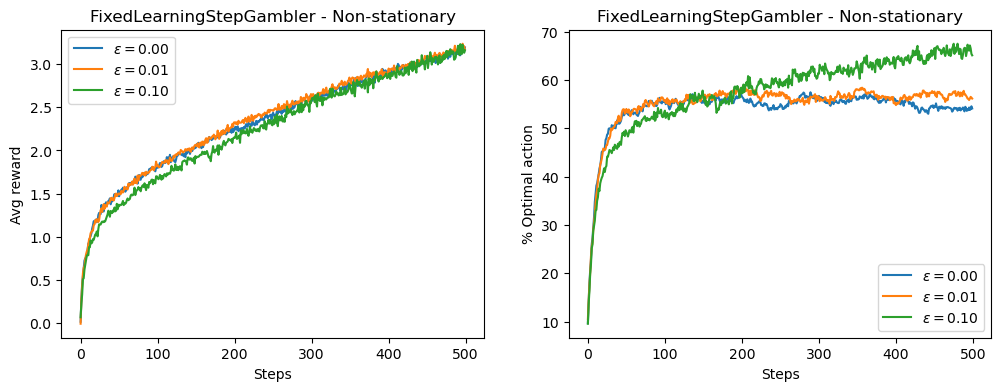

In [9]:
exercise_2_5(
    MultiArmedBanditEnv(stationary=False), FixedLearningStepGambler, {"alpha": 0.1}
)
exercise_2_5(
    MultiArmedBanditEnv(stationary=False), FixedLearningStepGambler, {"alpha": 0.8}
)
